In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import operator, math, os, glob
import torch.nn as nn
from matplotlib.pyplot import imread


from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [2]:
def euclidean_distance(vec1, vec2) :
  distance = np.linalg.norm(vec1 - vec2)
  return distance

In [3]:
def getkVoisins(features_dict, query_name, k):
  query_feature = features_dict[query_name]
  distances = []
  for name, feature_vector in features_dict.items():
    dist = euclidean_distance(query_feature, feature_vector)
    distances.append((name,dist))
  #print(distances)
  distances.sort(key=lambda x: x[1])
  return distances[:k]

In [14]:
import requests
import zipfile
import os
import shutil


if os.path.exists("MIR_DATASETS_"):
    print("Le dossier existe déjà.")
else:
    # URL du fichier zip
    url = "https://github.com/sidimahmoudi/facenet_tf2/releases/download/AI_MIR_CLOUD/MIR_DATASETS_B.zip"

    # Nom du fichier zip local
    fichier_zip = "MIR_DATASETS_B.zip"

    # Dossier d'extraction
    dossier_extraction = "MIR_DATASETS_B"

    # 1. Supprimer l'ancien dossier s'il existe
    if os.path.exists(dossier_extraction):
        print(f"Suppression de l'ancien dossier : {dossier_extraction}")
        shutil.rmtree(dossier_extraction)

    # 2. Télécharger le fichier zip
    print("Téléchargement en cours...")
    response = requests.get(url, stream=True)
    with open(fichier_zip, 'wb') as f:
        shutil.copyfileobj(response.raw, f)
    print("Téléchargement terminé.")

    # 3. Extraire le fichier zip
    print("Extraction en cours...")
    with zipfile.ZipFile(fichier_zip, 'r') as zip_ref:
        zip_ref.extractall(dossier_extraction)
    print(f"Extraction terminée dans le dossier : {dossier_extraction}")

    # 4. (Optionnel) Supprimer le fichier zip
    os.remove(fichier_zip)
    print("Fichier zip supprimé.")
    

    # Chemin vers le dossier à supprimer
    dossier_a_supprimer = 'MIR_DATASETS_B/MIR_DATASETS_B/araignees'

    # Vérifie si le dossier existe avant de le supprimer
    if os.path.exists(dossier_a_supprimer):
        shutil.rmtree(dossier_a_supprimer)
        print("Dossier supprimé avec succès.")
    else:
        print("Le dossier n'existe pas.")


Suppression de l'ancien dossier : MIR_DATASETS_B
Téléchargement en cours...
Téléchargement terminé.
Extraction en cours...
Extraction terminée dans le dossier : MIR_DATASETS_B
Fichier zip supprimé.
Dossier supprimé avec succès.


In [15]:
feature_extractor = models.vgg16(pretrained=True)
feature_extractor.eval()  # Mode évaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
input_folder = "MIR_DATASETS_B/MIR_DATASETS_B"
output_folder = "output"                  #VGG16
os.makedirs(output_folder, exist_ok=True)  # Créer le dossier s'il n'existe pas
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Taille standard de VGG16
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [17]:
def extract_features(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = feature_extractor(image)
    return features.cpu().numpy().squeeze().flatten()


In [21]:
import os
import numpy as np

# Suppose que ces variables sont définies quelque part :
# input_folder = "chemin/vers/le/dossier/images"
# output_folder = "chemin/vers/le/dossier/features"
# extract_features(image_path) doit être définie aussi

for classe in os.listdir(input_folder):
    classe_path = os.path.join(input_folder, classe)
    if not os.path.isdir(classe_path):
        continue
    print(classe)

    for sub_classe in os.listdir(classe_path):
        sub_classe_path = os.path.join(classe_path, sub_classe)
        if not os.path.isdir(sub_classe_path):
            continue
        print(sub_classe)

        for filename in os.listdir(sub_classe_path):
            if filename.lower().endswith(".jpg"):
                image_path = os.path.join(sub_classe_path, filename)
                features = extract_features(image_path)

                # Crée le même sous-dossier dans output_folder
                output_subfolder = os.path.join(output_folder, classe, sub_classe)
                os.makedirs(output_subfolder, exist_ok=True)

                output_path = os.path.join(output_subfolder, filename.split('.')[0] + ".txt")
                np.save(output_path, features)

                print(f"Features extraites et enregistrées : {output_path}")

print("Indexation terminée")


chiens
boxer
Features extraites et enregistrées : output\chiens\boxer\1_2_chiens_boxer_1108.txt
Features extraites et enregistrées : output\chiens\boxer\1_2_chiens_boxer_1109.txt
Features extraites et enregistrées : output\chiens\boxer\1_2_chiens_boxer_1110.txt
Features extraites et enregistrées : output\chiens\boxer\1_2_chiens_boxer_1111.txt
Features extraites et enregistrées : output\chiens\boxer\1_2_chiens_boxer_1112.txt
Features extraites et enregistrées : output\chiens\boxer\1_2_chiens_boxer_1113.txt
Features extraites et enregistrées : output\chiens\boxer\1_2_chiens_boxer_1114.txt
Features extraites et enregistrées : output\chiens\boxer\1_2_chiens_boxer_1115.txt
Features extraites et enregistrées : output\chiens\boxer\1_2_chiens_boxer_1116.txt
Features extraites et enregistrées : output\chiens\boxer\1_2_chiens_boxer_1117.txt
Features extraites et enregistrées : output\chiens\boxer\1_2_chiens_boxer_1118.txt
Features extraites et enregistrées : output\chiens\boxer\1_2_chiens_boxer_

In [29]:

def load_features_with_images(feature_folder, image_folder):
    # Récupère tous les fichiers .txt dans tous les sous-dossiers
    feature_files = sorted(glob.glob(os.path.join(feature_folder, "**", "*.npy"), recursive=True))

    features_dict = {}
    image_dict = {}

    for file in feature_files:
        feature_vector = np.load(file)
        base_name = os.path.splitext(os.path.basename(file))[0]

        # Stocker les features
        features_dict[base_name] = feature_vector

        # Recherche de l'image correspondante (même sous-structure que features)
        rel_path = os.path.relpath(file, feature_folder)  # ex: classe/sub_classe/nom.txt
        rel_image_path = os.path.splitext(rel_path)[0] 
        rel_image_path = rel_image_path.removesuffix(".txt")+ ".jpg"  # classe/sub_classe/nom.jpg
        print(rel_image_path)
        image_path = os.path.join(image_folder, rel_image_path)

        if os.path.exists(image_path):
            image_dict[base_name] = image_path
        else:
            print(f"Aucune image trouvée pour {file} (attendu : {image_path})")

    print(f"{len(features_dict)} caractéristiques chargées avec images depuis {feature_folder}")
    return features_dict, image_dict

In [30]:
features_dict, image_dict = load_features_with_images(output_folder, input_folder)

chiens\Chihuahua\1_3_chiens_Chihuahua_1264.jpg
chiens\Chihuahua\1_3_chiens_Chihuahua_1265.jpg
chiens\Chihuahua\1_3_chiens_Chihuahua_1266.jpg
chiens\Chihuahua\1_3_chiens_Chihuahua_1267.jpg
chiens\Chihuahua\1_3_chiens_Chihuahua_1268.jpg
chiens\Chihuahua\1_3_chiens_Chihuahua_1269.jpg
chiens\Chihuahua\1_3_chiens_Chihuahua_1270.jpg
chiens\Chihuahua\1_3_chiens_Chihuahua_1271.jpg
chiens\Chihuahua\1_3_chiens_Chihuahua_1272.jpg
chiens\Chihuahua\1_3_chiens_Chihuahua_1273.jpg
chiens\Chihuahua\1_3_chiens_Chihuahua_1274.jpg
chiens\Chihuahua\1_3_chiens_Chihuahua_1275.jpg
chiens\Chihuahua\1_3_chiens_Chihuahua_1276.jpg
chiens\Chihuahua\1_3_chiens_Chihuahua_1277.jpg
chiens\Chihuahua\1_3_chiens_Chihuahua_1278.jpg
chiens\Chihuahua\1_3_chiens_Chihuahua_1279.jpg
chiens\Chihuahua\1_3_chiens_Chihuahua_1280.jpg
chiens\Chihuahua\1_3_chiens_Chihuahua_1281.jpg
chiens\Chihuahua\1_3_chiens_Chihuahua_1282.jpg
chiens\Chihuahua\1_3_chiens_Chihuahua_1283.jpg
chiens\Chihuahua\1_3_chiens_Chihuahua_1284.jpg
chiens\Chihua

In [31]:
def recherche(query_name, features_dict, image_dict, top=9):
    voisins = getkVoisins(features_dict, query_name, top)
    # Récupérer les chemins des images similaires
    nom_images_proches = [image_dict[v[0]] for v in voisins if v[0] in image_dict]
    # Affichage de l'image requête
    plt.figure(figsize=(5, 5))
    plt.imshow(imread(image_dict[query_name]), cmap='gray', interpolation='none')
    plt.title("Image requête")
    nom_image_requete = os.path.basename(image_dict[query_name])
    print(f"Image requête : {nom_image_requete}")
    # Affichage des images proches
    plt.figure(figsize=(25, 50))
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    num_rows = int(math.ceil(top / 3))  # 3 subplots per row
    num_cols = min(top, 3)
    for j in range(min(top, len(nom_images_proches))):
        plt.subplot(num_rows, num_cols, j + 1)
        nom_images_short = nom_images_proches[j].split("/")[-1]
        plt.imshow(imread(nom_images_proches[j]), cmap='gray', interpolation='none')
        plt.title(f"Image proche n°{j} {nom_images_short}")
    return nom_image_requete, nom_images_proches


KeyError: 0

Image requête : 1_3_chiens_Chihuahua_1264.jpg


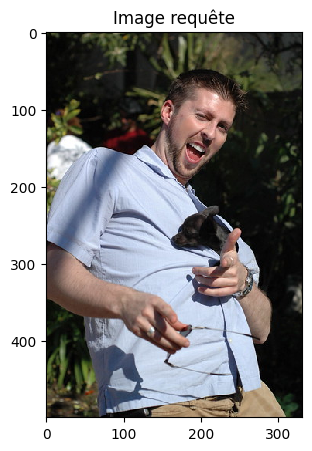

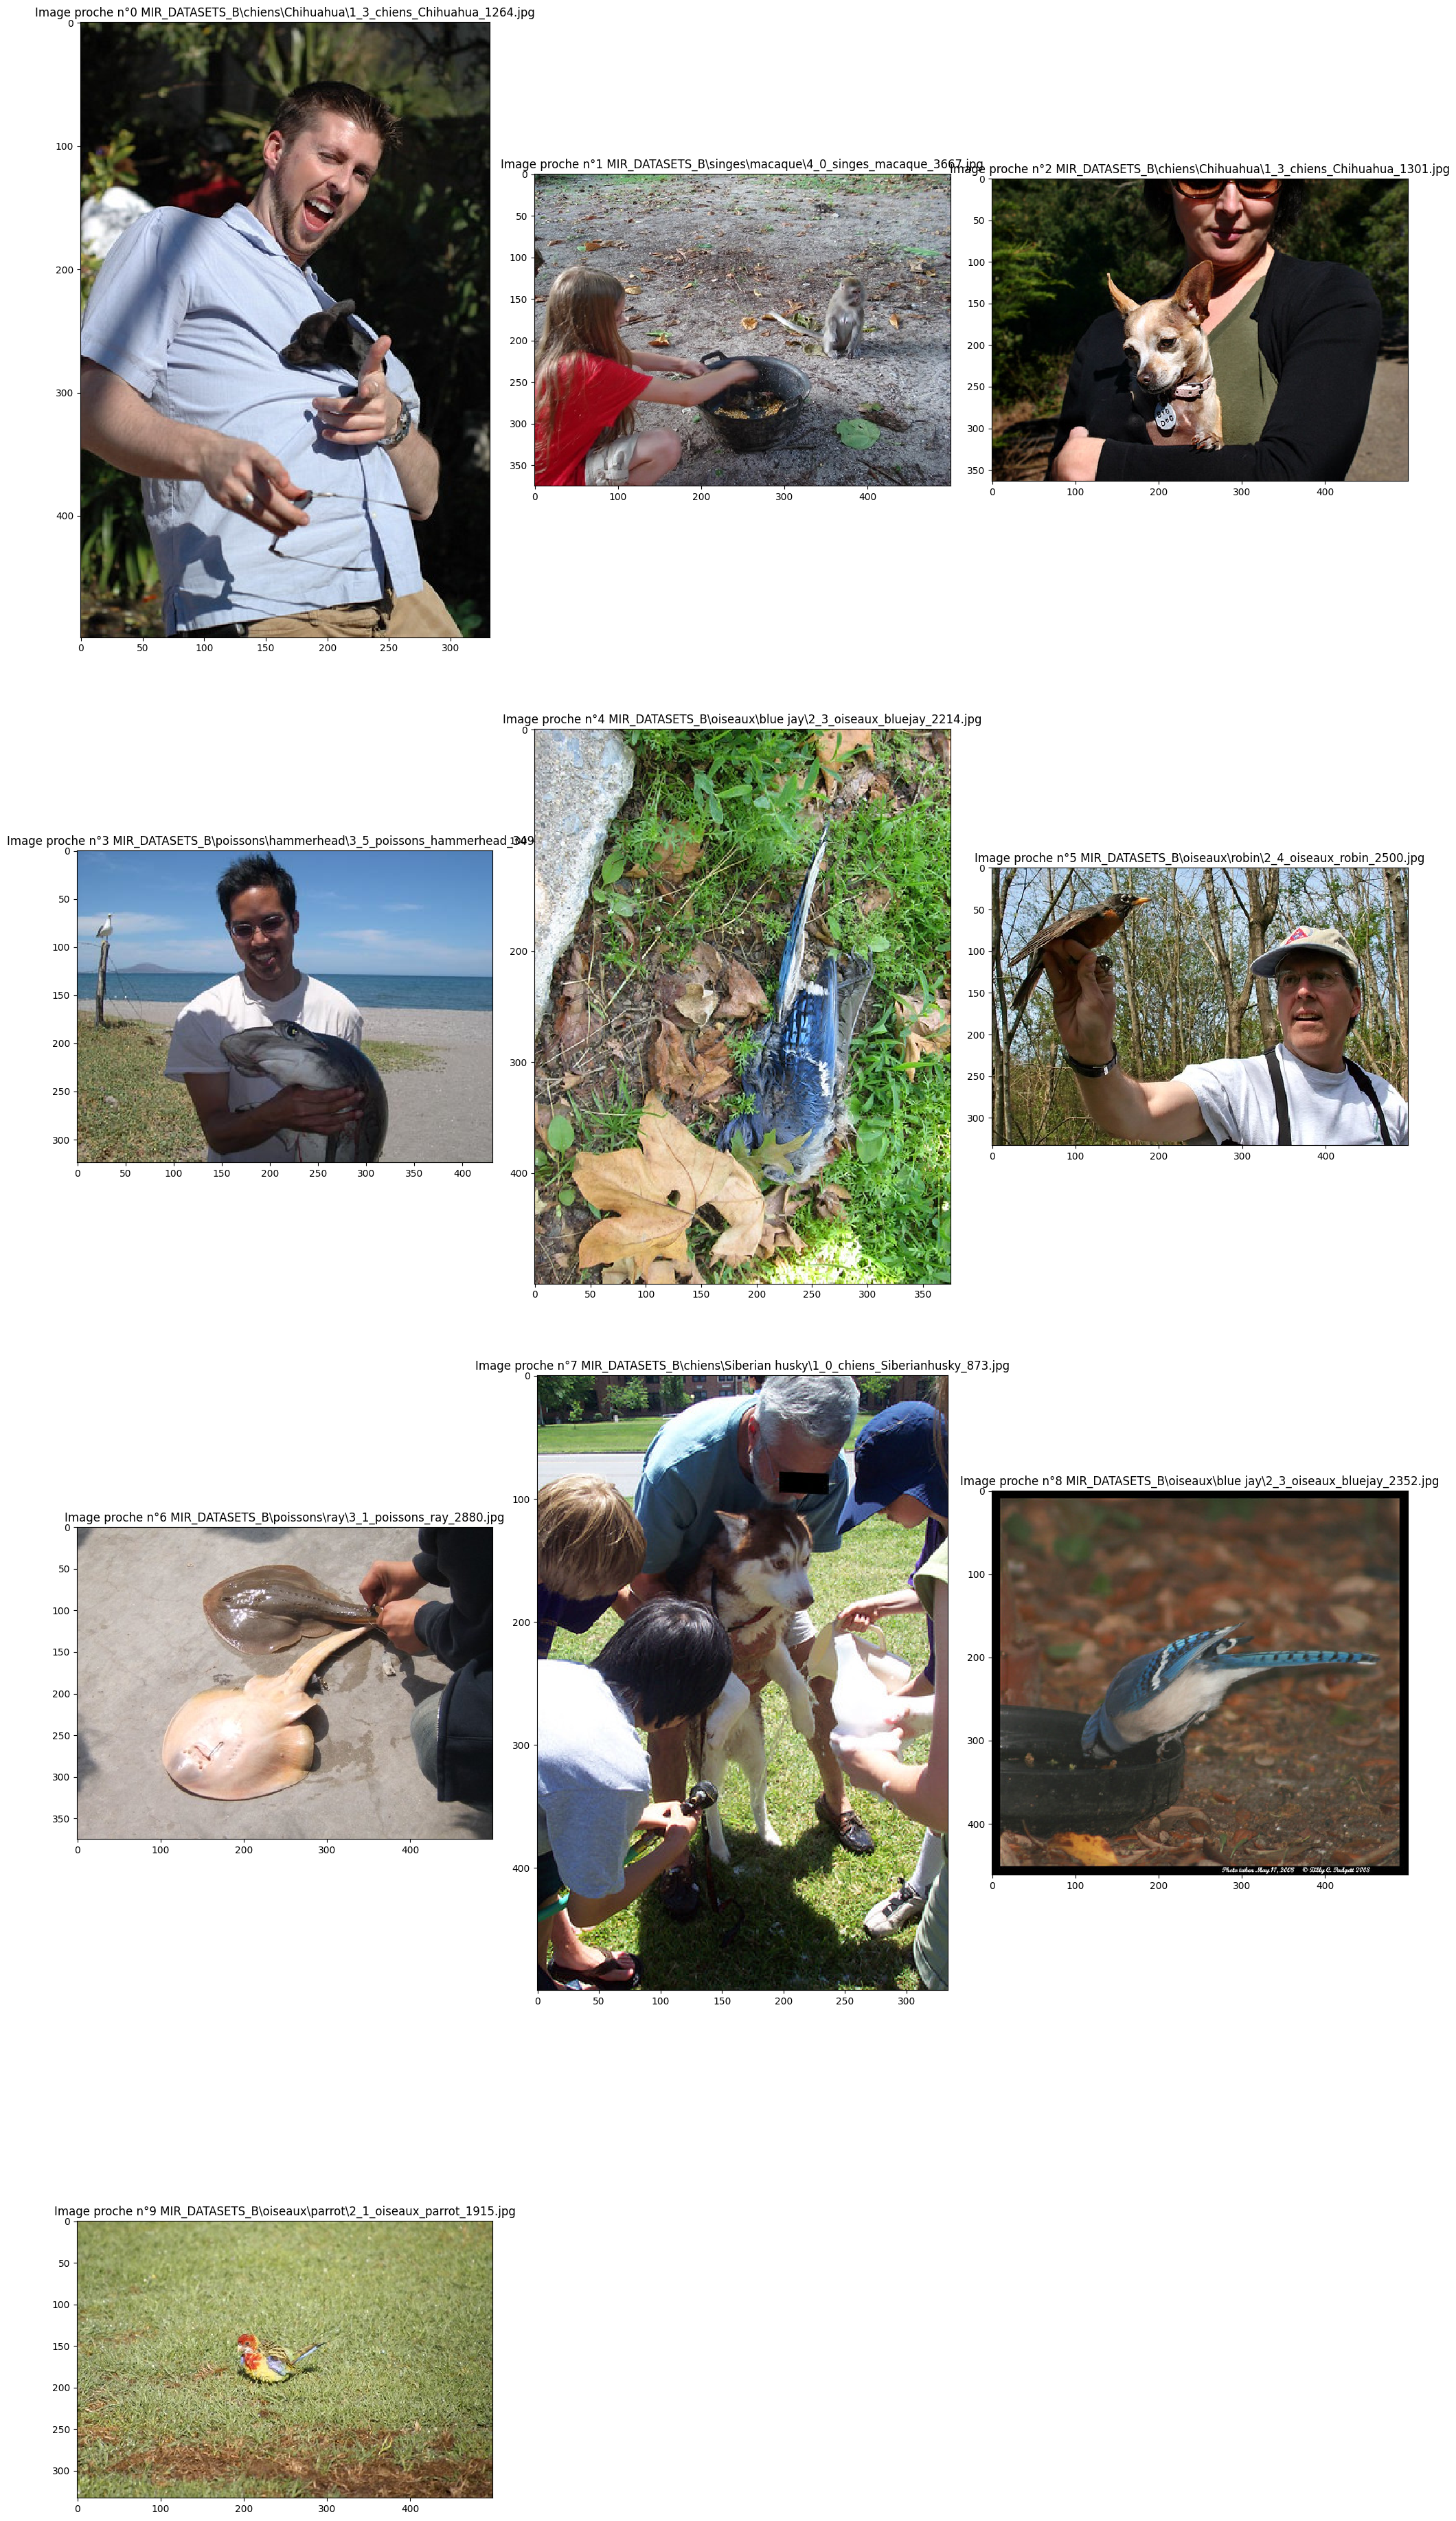

In [39]:
nom_image_requete, nom_images_proches = recherche("1_3_chiens_Chihuahua_1264.txt", features_dict, image_dict, top=10)

In [40]:
def Compute_RP( top, nom_image_requete, images_proches,race = True):

    rappel_precision = []
    rp = []
    position1 = os.path.splitext(os.path.basename(nom_image_requete))[0]

    if race :
        position1 = position1.split("_")[3]
    else :
        position1 = position1.split("_")[2]
    for j in range(top):
        position2 = os.path.splitext(os.path.basename(images_proches[j]))[0]

        if race:
            position2 = position2.split("_")[3]
        else:
            position2 = position2.split("_")[2]
        print("position 1 ", position1)
        print("position 2 ", position2)
        if position1 == position2:
            rappel_precision.append("pertinent")
            print("pertinent")
        else:
            rappel_precision.append("non pertinent")
            print("non pertinent")

    val = 0  # Nombre d'images pertinentes accumulées
    for i in range(top):
        if rappel_precision[i] == "pertinent":
            val += 1
        precision = val / (i + 1)
        rappel = val / top
        rp.append(f"{precision} {rappel}")  # Stocker les valeurs
    RP_file = str(os.path.splitext(os.path.basename(nom_image_requete))[0]) + 'RP.txt'
    #  Sauvegarde dans un fichier texte
    with open(RP_file, 'w') as s:
        for a in rp:
            s.write(str(a) + '\n')
    print(f"✅ RP enregistré dans {RP_file}")


In [41]:
Compute_RP(10, nom_image_requete, nom_images_proches,race = False)

position 1  chiens
position 2  chiens
pertinent
position 1  chiens
position 2  singes
non pertinent
position 1  chiens
position 2  chiens
pertinent
position 1  chiens
position 2  poissons
non pertinent
position 1  chiens
position 2  oiseaux
non pertinent
position 1  chiens
position 2  oiseaux
non pertinent
position 1  chiens
position 2  poissons
non pertinent
position 1  chiens
position 2  chiens
pertinent
position 1  chiens
position 2  oiseaux
non pertinent
position 1  chiens
position 2  oiseaux
non pertinent
✅ RP enregistré dans 1_3_chiens_Chihuahua_1264RP.txt


In [42]:
def Display_RP(fichier):
    x, y  = [], []
    with open(fichier, 'r') as txtfile:
        for line in txtfile:
            values = line.strip().split()
            if len(values) == 2:
                x.append(float(values[0])) # Précision
                y.append(float(values[1])) # Rappel
    x_tensor = torch.tensor(x)
    y_tensor = torch.tensor(y)

    plt.figure(figsize=(8,6))
    plt.plot(y_tensor, x_tensor, 'C1', label= "VGG16")
    plt.xlabel('Rappel')
    plt.ylabel('Precision')
    plt.title("Courbe Rappel/Precision")
    plt.legend()
    plt.grid(True)
    plt.show()


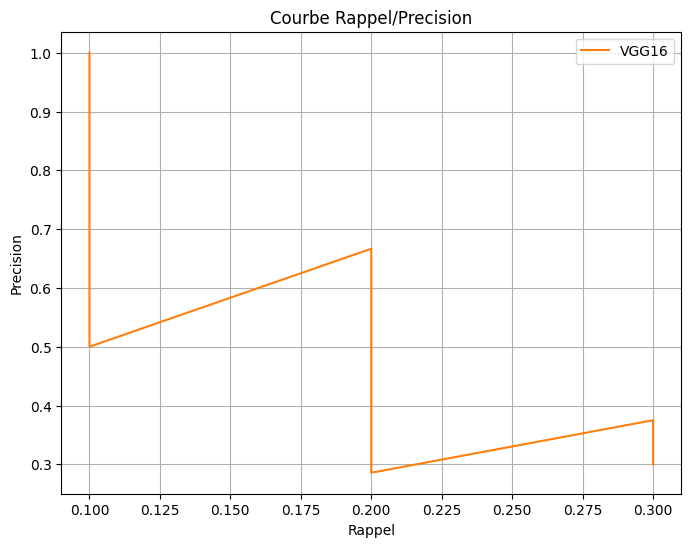

In [43]:
Display_RP("1_3_chiens_Chihuahua_1264RP.txt")

In [44]:
#Mr GPT
# # 1. Charger modèle pré-entraîné
# model = models.vgg16(pretrained=True)
# num_classes = 24

# # 2. Remplacer le classifier
# model.classifier[6] = nn.Linear(4096, num_classes)

# # 3. Optionnel : figer les premières couches
# for param in model.features.parameters():
#     param.requires_grad = False

# # 4. Préparer les données
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])

# train_dataset = ImageFolder(root="/content/MIR_DATASETS_B/MIR_DATASETS_B", transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# # 5. Entraînement
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# model.train()

# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# criterion = nn.CrossEntropyLoss()

# for epoch in range(5):  # adapte le nombre d'époques
#     running_loss = 0.0
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#     print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

In [45]:
# from sklearn.metrics import accuracy_score

# model.eval()
# all_preds, all_labels = [], []
# with torch.no_grad():
#     for images, labels in val_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         _, preds = torch.max(outputs, 1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# print("Accuracy:", accuracy_score(all_labels, all_preds))
